# Finding local maxima
***
Essentially all of our data is a bunch of binking dots. This notebook lays out a method for identifing those dots computationally. In principle, the method works by averaging over local areas, and assuming that strong features will persist though an image blurs, while weaker signals, like noise, will be lost in the process.  We are going to start off by bringing in matplotlib as `inline` (which lacks the interactivity) and opening up a test image with a single well defined maximum. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
fname = 'test_images/test_image_1.tif'

In [3]:
from skimage.external.tifffile import imread
im = imread(fname)

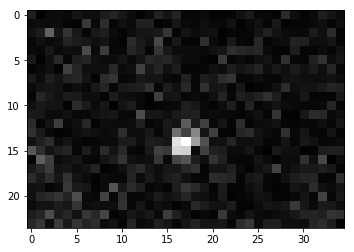

In [4]:
plt.imshow(im, cmap = "binary_r")

Now we are going to apply maximum and minimum filters. In principle we are going to go to each pixel in the image and draw a box with dimensions `size` around it. We then set the value of the pixel equal to the pixel in the box with the highest or lowest value. In practice, we just call the filter from skimage.
_Note: the filter settings will need to be determined empirically and often_.

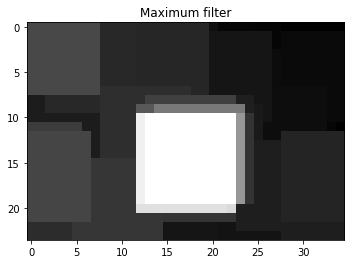

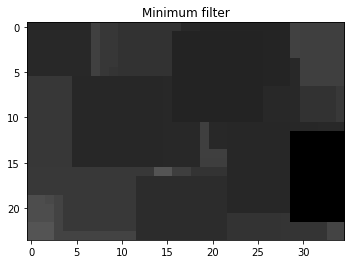

In [5]:
import scipy.ndimage.filters as filters
size = 10
im_max = filters.maximum_filter(im, size)
im_min = filters.minimum_filter(im, size)
plt.figure()
plt.title("Maximum filter")
plt.imshow(im_max, cmap = "binary_r",vmax = 3000)
plt.figure()
plt.title("Minimum filter")
plt.imshow(im_min, cmap = "binary_r",vmax = 300)

Any true maxima ought to be represented in the maximum filtered image. To find potential candidates, we ask for all the pixels that have the same value in both the filtered and unfiltered image.

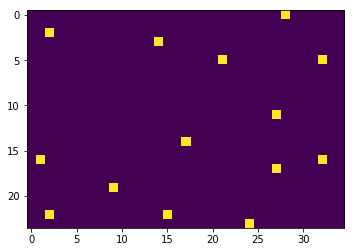

In [6]:
maxima=(im==im_max)
plt.imshow(maxima)

One or more of these yellow pixels defines a local maximum. In order to determine which ones are bona fide, we create a mask from our filitered images and compare. We make the mask by determining the difference between the maximum and minimum filtered images and thresholding the data. In principle, the first step should average over image noise that dominates in regions that do not contain maxima. In noise dominated regions, maximum values and minimum values should be roughly equal depending on the size of the filter (larger sizes yield larger differences). By subtracting them, we should create an image where the local vicinity of maxima is represented by values well seperated from background. Depending on the quality of the image and the size of the filter, subtracting the minimum background may have little to no effect. The second step of thresholding the image turns the numerical array into a boolean array, where above the threshold evaluates as `True` and below as `False`.

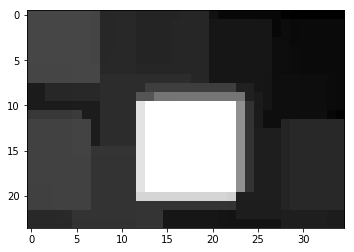

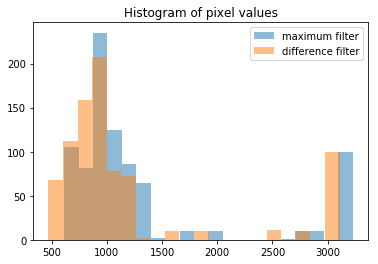

In [7]:
im_diff = im_max - im_min
plt.imshow(im_diff,cmap = "binary_r",vmax = 3000)

plt.figure()
plt.title("Histogram of pixel values")
plt.hist(im_max.ravel(), 20, alpha = 0.5, label = "maximum filter")
plt.hist(im_diff.ravel(), 20, alpha = 0.5, label = "difference filter")
plt.legend()

Next we determine the threshold. There are other ways to determine thresholds, below is just one.

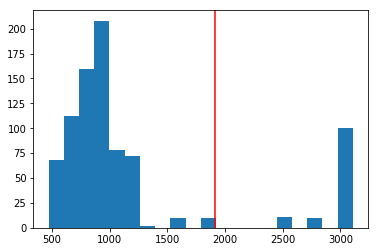

In [8]:
from skimage.filters import threshold_otsu
thresh = threshold_otsu(im_diff)
plt.hist(im_diff.ravel(), 20)
plt.axvline(thresh, color='r')

Now we apply the threshold to the difference array and define our new array which is constituted by booleans.

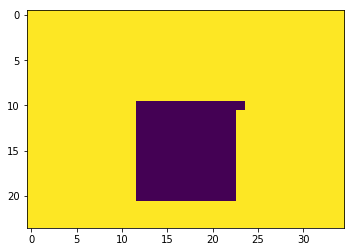

In [9]:
bool_diff = (im_diff < thresh)
plt.imshow(bool_diff)

Great, our maxima is in the purple region of our difference mask. So all that is left is to compare the array `maxima`, which contains both real and _less real_ maxima, to the difference mask. Specifically, we want to ask for all of the points that occur in `maxima` in regions where `bool_diff` is above the threshold.

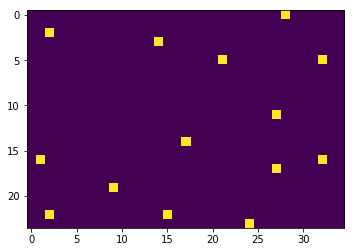

In [10]:
plt.imshow(maxima)

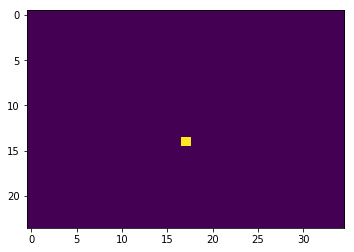

In [11]:
#-- Below is a fun little bit of python fancy indexing.
#-- What is happening is the array maxima is being indexed by the difference mask. 
#-- Whenever the mask array is True we set the corresponding value in the maxima array to False.
#-- Alternatively, we do nothing when maxima is indexed by false.
maxima[bool_diff] = False
plt.imshow(maxima)

We can then recover the xy position of the maxima and paint them onto the original image.

In [12]:
import scipy.ndimage as ndimage
labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)

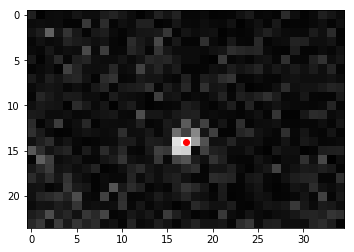

In [13]:
x, y = [], []
for dy,dx in slices:
    x.append(dx.start)   
    y.append(dy.start)

plt.imshow(im,cmap = "binary_r")
plt.plot(x,y, 'ro')

Okay, now we are going to put it all together on an image with many maxima to see how it does. 

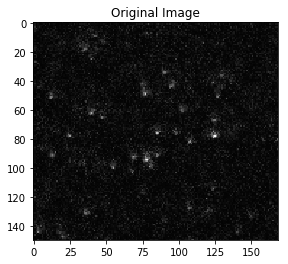

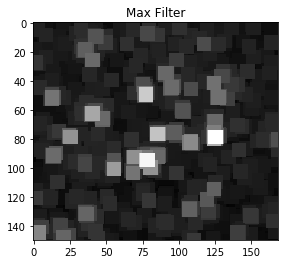

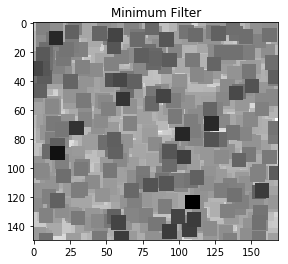

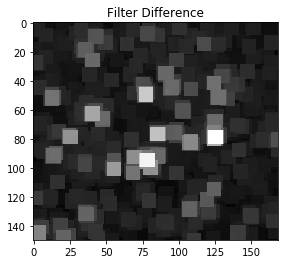

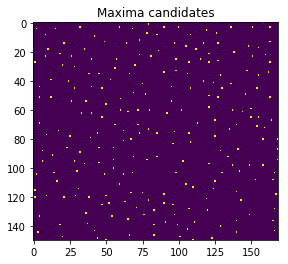

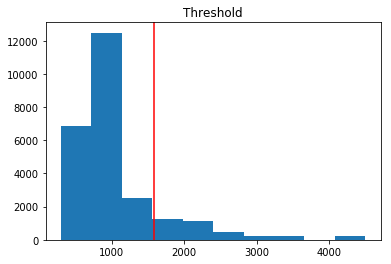

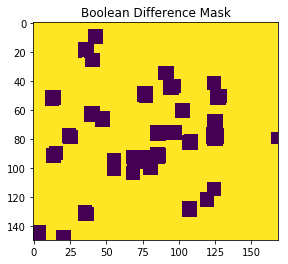

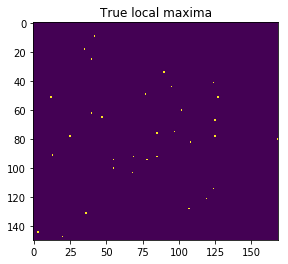

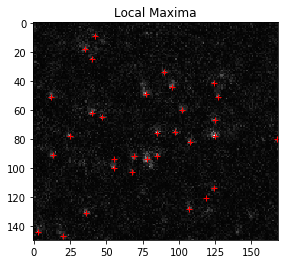

In [14]:
fname = 'test_image_2.tif'
im = imread(fname)
plt.figure()
plt.imshow(im, cmap = "binary_r")
plt.title("Original Image")
size = 10
im_max = filters.maximum_filter(im, size)
im_min = filters.minimum_filter(im, size)
plt.figure()
plt.title("Max Filter")
plt.imshow(im_max, cmap = "binary_r")
plt.figure()
plt.title("Minimum Filter")
plt.imshow(im_min, cmap = "binary_r")
im_diff = im_max - im_min
plt.figure()
plt.title("Filter Difference")
plt.imshow(im_diff,cmap = "binary_r")
maxima=(im==im_max)
plt.figure()
plt.title("Maxima candidates")
plt.imshow(maxima)
thresh = threshold_otsu(im_diff)
plt.figure()
plt.title("Threshold")
plt.hist(im_diff.ravel())
plt.axvline(thresh, color='r')
plt.figure()
plt.title("Boolean Difference Mask")
bool_diff = (im_diff < thresh)
plt.imshow(bool_diff)
maxima[bool_diff] = False
plt.figure()
plt.title("True local maxima")
plt.imshow(maxima)
labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
x, y = [], []
for dy,dx in slices:
    x.append(dx.start)   
    y.append(dy.start)
plt.figure()
plt.title("Local Maxima")
plt.imshow(im,cmap = "binary_r")
plt.plot(x,y, 'r+')

Finally, putting the original and maxima painted images next to one another shows that the algortithn works pretty okay. _But never trust a computer to do your job. Computers be lyin' sometimes._ 

Text(0.5,1,'Original Image')

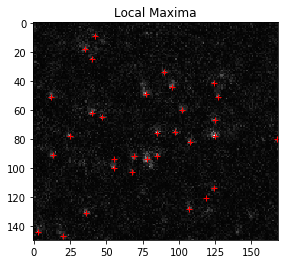

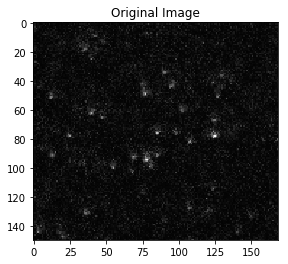

In [15]:
plt.title("Local Maxima")
plt.imshow(im,cmap = "binary_r")
plt.plot(x,y, 'r+')
plt.figure()
plt.imshow(im, cmap = "binary_r")
plt.title("Original Image")